<a href="https://colab.research.google.com/github/rizalagussaini/telco_churn_app/blob/main/%232%20Copy_of_churn_Pengembangan%20Model_Rizal_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightgbm
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


# EDA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load the data file
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Churn
No     5174
Yes    1869
Name: count, dtype: int64


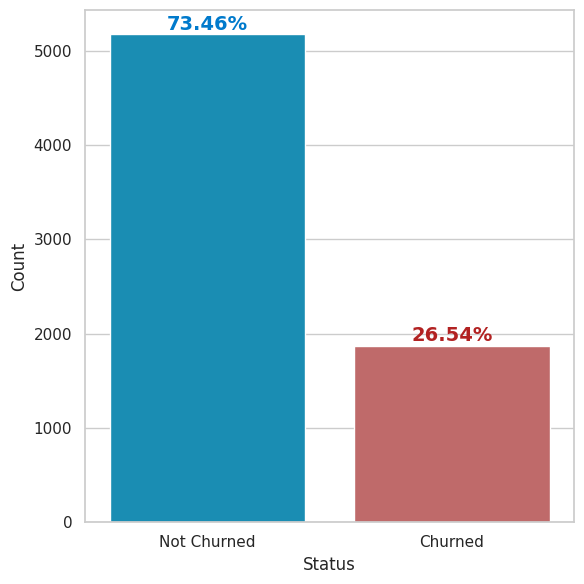

In [6]:
# Hitung jumlah dan persentase
print(df['Churn'].value_counts())

count = df['Churn'].value_counts()
percent = df['Churn'].value_counts(normalize=True) * 100

labels = ['Not Churned' if val == 'No' else 'Churned' for val in count.index]

plt.figure(figsize=(6, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x=labels, y=count.values, hue=labels, palette=['#009ACD', '#CD5C5C'], legend=False)

for i, p in enumerate(count.values):
    percentage = f"{percent.iloc[i]:.2f}%"
    color = '#007ACC' if labels[i] == 'Not Churned' else '#B22222'
    plt.text(i, p + 50, percentage, ha='center', color=color, fontsize=14, fontweight='bold')

plt.xlabel('Status')
plt.ylabel('Count')
plt.title('')
plt.tight_layout()
plt.show()

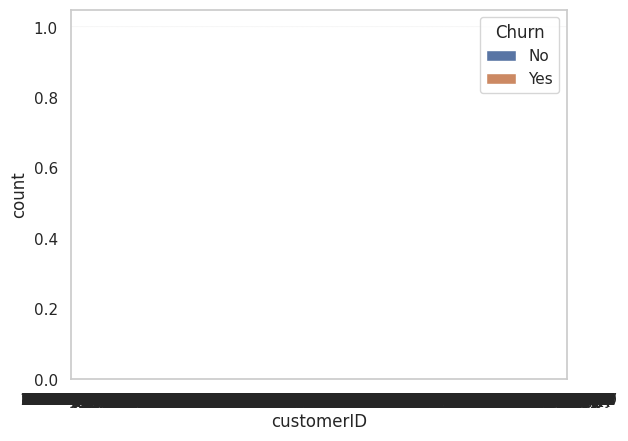

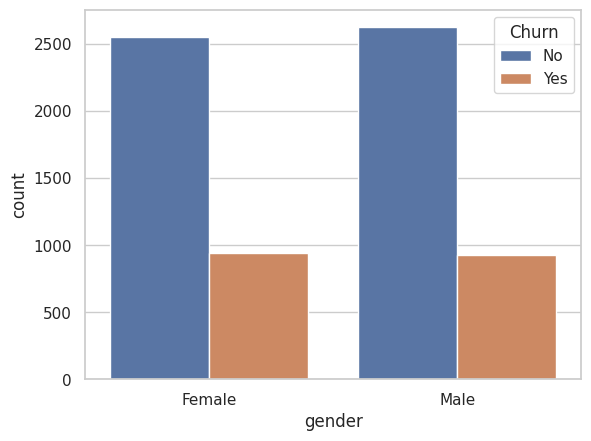

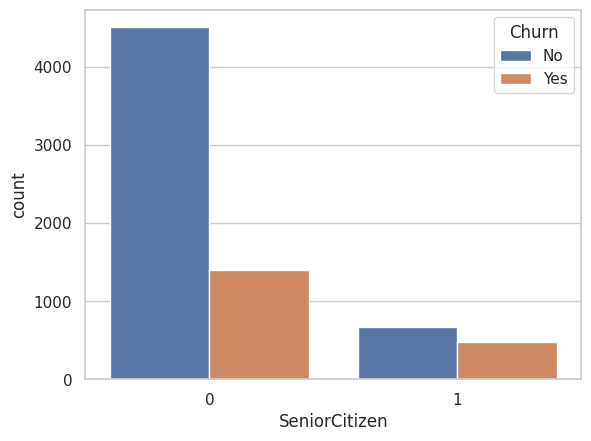

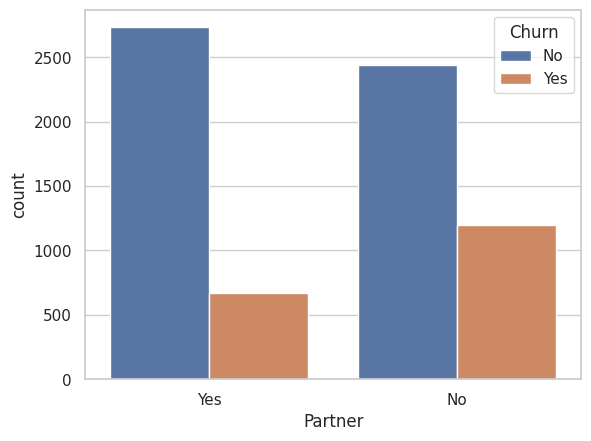

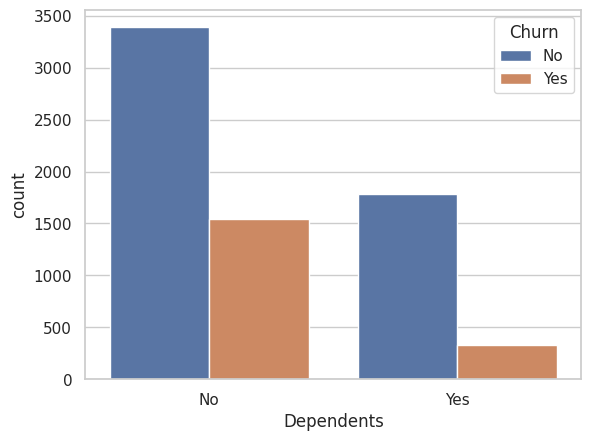

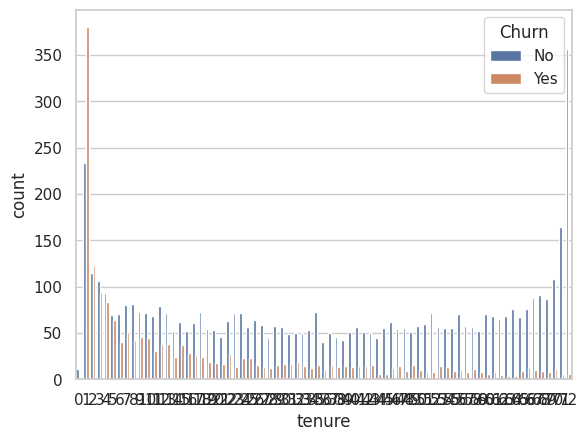

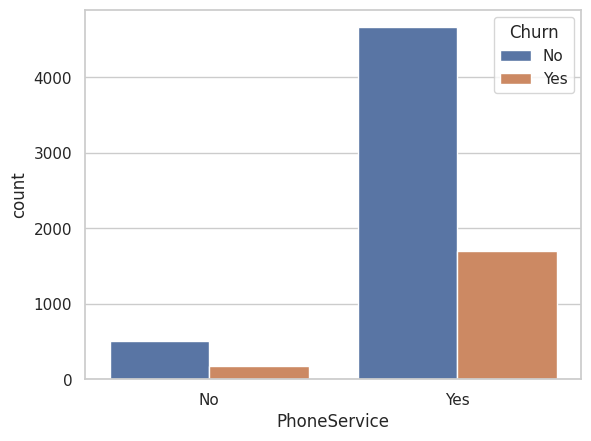

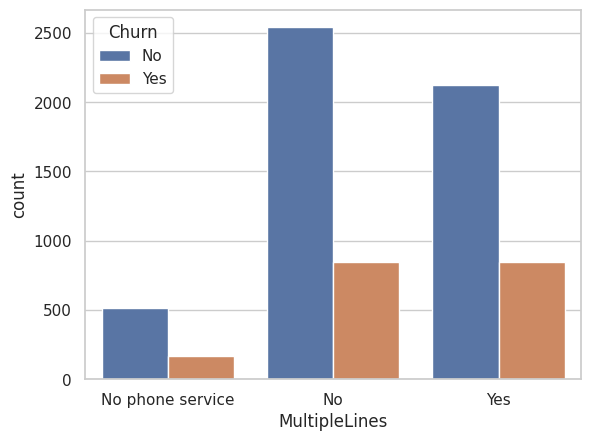

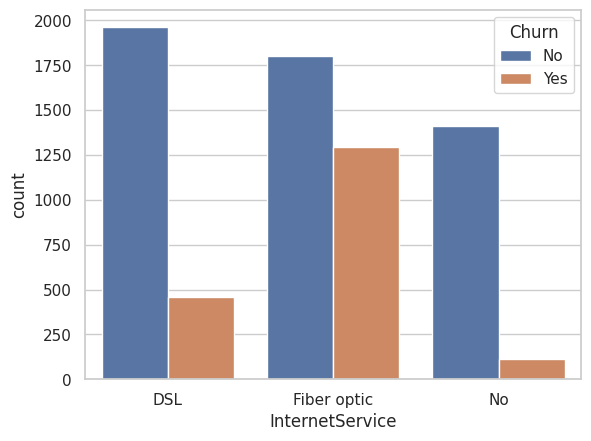

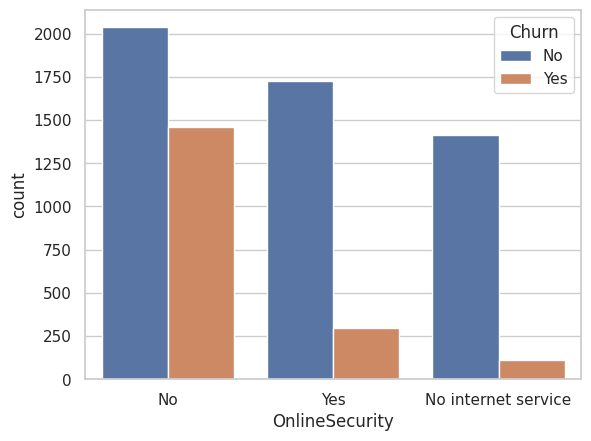

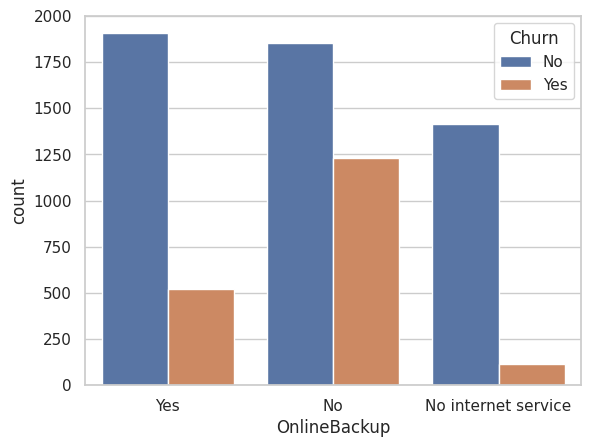

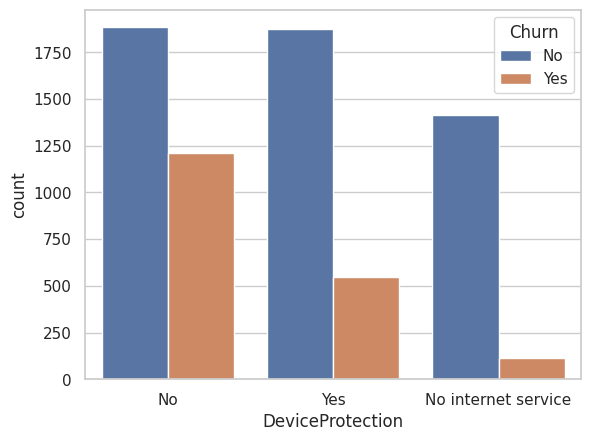

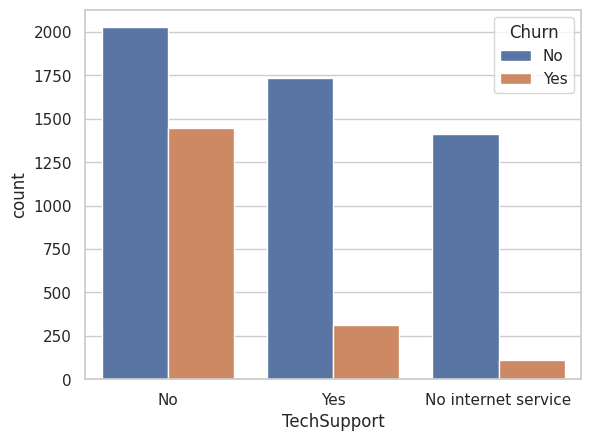

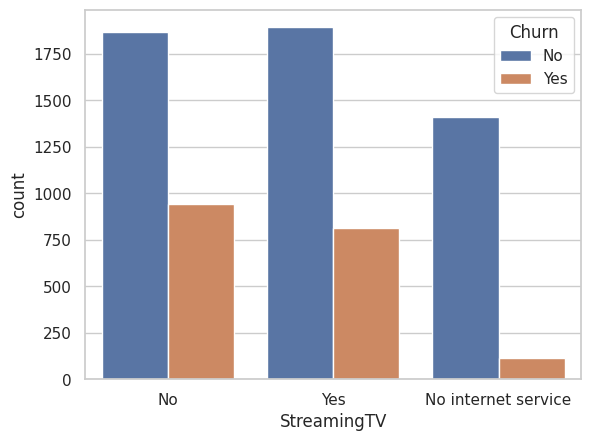

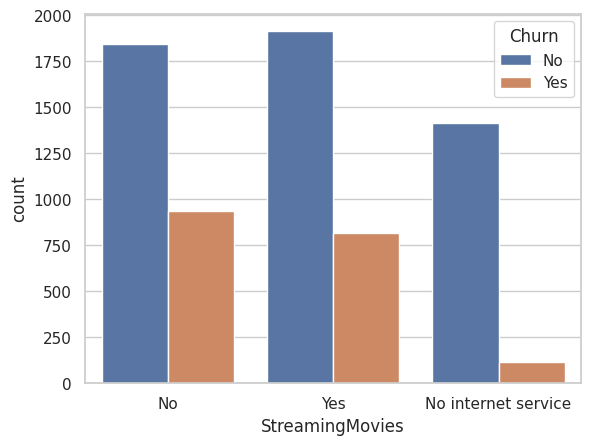

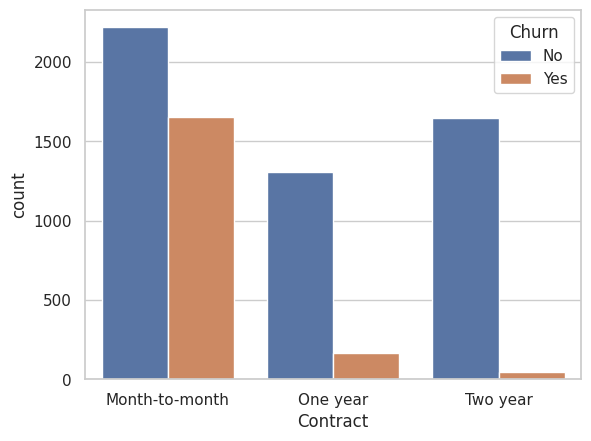

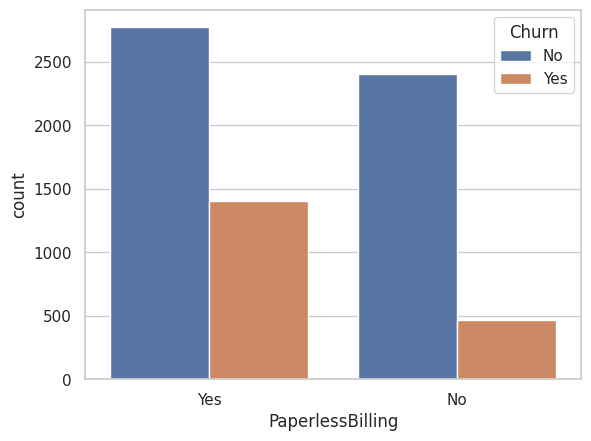

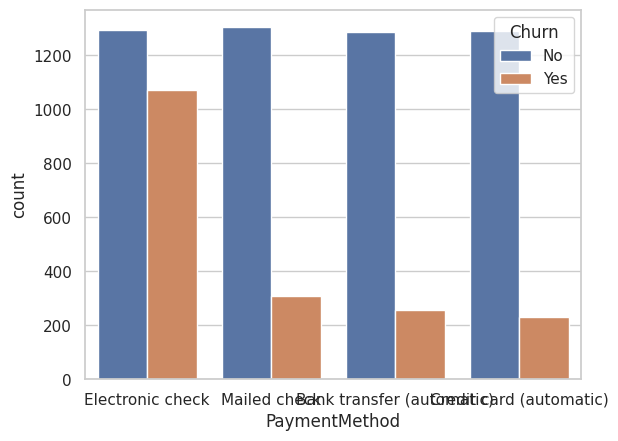

In [7]:
# Distribusi dari setiap fitur dengan Churn.
for i, predictor in enumerate(df.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges'])):
    plt.figure(i)
    sns.countplot(data=df, x=predictor, hue='Churn')

# Preprocessing

In [8]:
# Create a copy of base data for manupulation & processing
telco_data = df.copy()

In [9]:
# Encode 'TotalCharges' and 'Churn'
telco_data['TotalCharges'] = pd.to_numeric(telco_data['TotalCharges'], errors='coerce')
telco_data['Churn'] = telco_data['Churn'].map({'Yes': 1, 'No': 0})

In [10]:
# check missing values
telco_data.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [11]:
# handling 'TotalCharges' missing values
telco_data.dropna(how='any', inplace=True)

In [12]:
# drop irrelevant columns
telco_data.drop(columns=['customerID'], inplace=True)

In [13]:
# Pengembangan dari Rizal
# Fitur baru: Rata-rata Pembayaran per Bulan
# Hindari pembagian dengan nol
telco_data = telco_data[telco_data['tenure'] != 0]
telco_data['AvgMonthlyPayment'] = telco_data['TotalCharges'] / telco_data['tenure']


In [14]:
# Pengembangan dari Rizal
# Fitur Interaksi: InternetService x Contract
telco_data['Internet_Contract'] = telco_data['InternetService'] + "_" + telco_data['Contract']


In [15]:
# check 'tenure' max value
print(telco_data['tenure'].max())

72


In [16]:
# making a gorup of tenure in range of 12 months each
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]
telco_data['tenure_group'] = pd.cut(telco_data.tenure, range(1, 80, 12), right=False, labels=labels)

In [17]:
telco_data['tenure_group'].value_counts()

,count
tenure_group,
1 - 12,2175
61 - 72,1407
13 - 24,1024
25 - 36,832
49 - 60,832
37 - 48,762


In [18]:
# Pengembangan dari Rizal
# Deteksi dan Penanganan Outlier (IQR Method)
# Deteksi outlier untuk 'MonthlyCharges' dan 'TotalCharges'
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

# Terapkan ke dua kolom
telco_data = remove_outliers_iqr(telco_data, 'MonthlyCharges')
telco_data = remove_outliers_iqr(telco_data, 'TotalCharges')


In [19]:
# encode all categorical columns
telco_data_dummies = pd.get_dummies(telco_data)
telco_data_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,AvgMonthlyPayment,gender_Female,gender_Male,Partner_No,Partner_Yes,...,Internet_Contract_Fiber optic_Two year,Internet_Contract_No_Month-to-month,Internet_Contract_No_One year,Internet_Contract_No_Two year,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,1,29.85,29.85,0,29.850000,True,False,False,True,...,False,False,False,False,True,False,False,False,False,False
1,0,34,56.95,1889.50,0,55.573529,False,True,True,False,...,False,False,False,False,False,False,True,False,False,False
2,0,2,53.85,108.15,1,54.075000,False,True,True,False,...,False,False,False,False,True,False,False,False,False,False
3,0,45,42.30,1840.75,0,40.905556,False,True,True,False,...,False,False,False,False,False,False,False,True,False,False
4,0,2,70.70,151.65,1,75.825000,True,False,True,False,...,False,False,False,False,True,False,False,False,False,False


In [20]:
telco_data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 62 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   SeniorCitizen                                 7032 non-null   int64  
 1   tenure                                        7032 non-null   int64  
 2   MonthlyCharges                                7032 non-null   float64
 3   TotalCharges                                  7032 non-null   float64
 4   Churn                                         7032 non-null   int64  
 5   AvgMonthlyPayment                             7032 non-null   float64
 6   gender_Female                                 7032 non-null   bool   
 7   gender_Male                                   7032 non-null   bool   
 8   Partner_No                                    7032 non-null   bool   
 9   Partner_Yes                                   7032 non-null   bool  

In [21]:
# convert all bool columns to numeric
bool_cols = telco_data_dummies.select_dtypes(include='bool').columns
telco_data_dummies[bool_cols] = telco_data_dummies[bool_cols].astype(int)

In [22]:
telco_data_dummies

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,AvgMonthlyPayment,gender_Female,gender_Male,Partner_No,Partner_Yes,...,Internet_Contract_Fiber optic_Two year,Internet_Contract_No_Month-to-month,Internet_Contract_No_One year,Internet_Contract_No_Two year,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,1,29.85,29.85,0,29.850000,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,34,56.95,1889.50,0,55.573529,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,2,53.85,108.15,1,54.075000,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
3,0,45,42.30,1840.75,0,40.905556,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,2,70.70,151.65,1,75.825000,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,1990.50,0,82.937500,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
7039,0,72,103.20,7362.90,0,102.262500,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
7040,0,11,29.60,346.45,0,31.495455,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
7041,1,4,74.40,306.60,1,76.650000,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0


<Axes: >

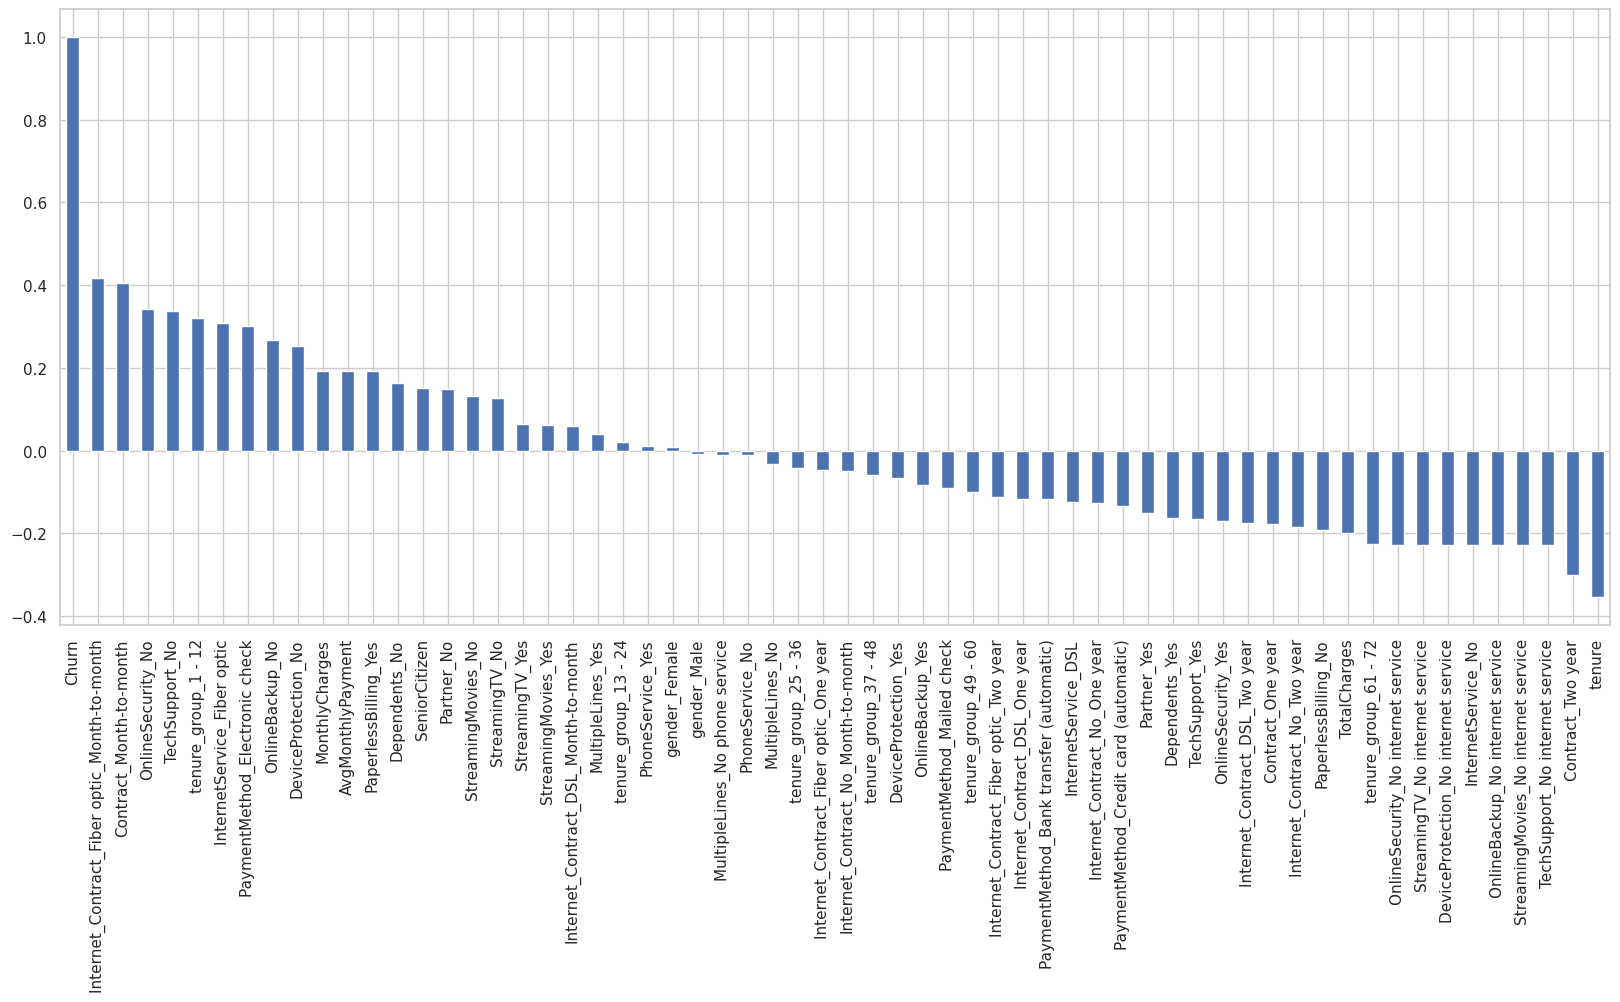

In [23]:
# Check features correlation with 'Churn'
plt.figure(figsize=(20,8))
telco_data_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

In [24]:
# drop irrelevant columns based on correlation result
telco_data_dummies.drop(columns=['gender_Male', 'gender_Female', 'PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No', 'MultipleLines_Yes', 'MultipleLines_No phone service'], inplace=True)

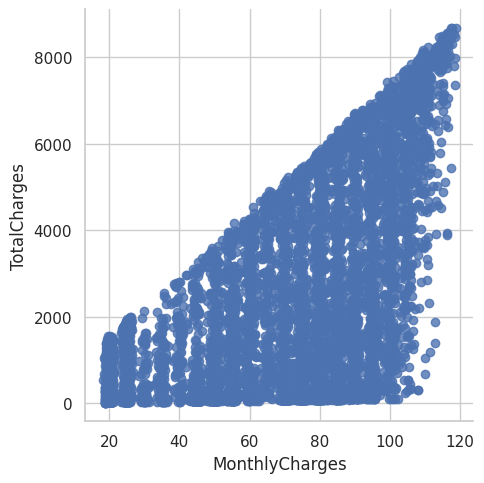

In [25]:
# Relationship between Monthly Charges and Total Charges
sns.lmplot(data=telco_data_dummies, x='MonthlyCharges', y='TotalCharges', fit_reg=False)

Text(0.5, 1.0, 'TotalCharges by churn')

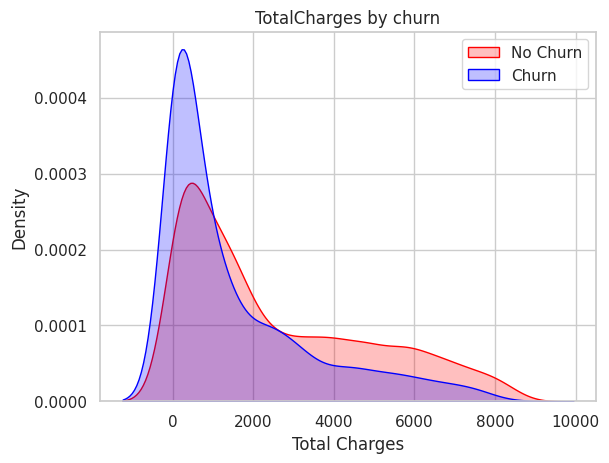

In [26]:
Tot = sns.kdeplot(telco_data_dummies.TotalCharges[(telco_data_dummies["Churn"] == 0)], color="Red", fill=True)
Tot = sns.kdeplot(telco_data_dummies.TotalCharges[(telco_data_dummies["Churn"] == 1)], ax=Tot, color="Blue", fill=True)

Tot.legend(["No Churn", "Churn"], loc='upper right')
Tot.set_ylabel('Density')
Tot.set_xlabel('Total Charges')
Tot.set_title('TotalCharges by churn')

In [28]:
telco_data_dummies.to_csv('tel_churn.csv')

In [29]:
# Import metrics evaluation from scikit-learn
from sklearn.model_selection import train_test_split

# handling imbalance
from imblearn.combine import SMOTEENN

In [30]:
# load dataset
df = pd.read_csv("tel_churn.csv")
df

,Unnamed: 0,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,AvgMonthlyPayment,Partner_No,Partner_Yes,Dependents_No,...,Internet_Contract_Fiber optic_Two year,Internet_Contract_No_Month-to-month,Internet_Contract_No_One year,Internet_Contract_No_Two year,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,0,1,29.85,29.85,0,29.850000,0,1,1,...,0,0,0,0,1,0,0,0,0,0
1,1,0,34,56.95,1889.50,0,55.573529,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2,2,0,2,53.85,108.15,1,54.075000,1,0,1,...,0,0,0,0,1,0,0,0,0,0
3,3,0,45,42.30,1840.75,0,40.905556,1,0,1,...,0,0,0,0,0,0,0,1,0,0
4,4,0,2,70.70,151.65,1,75.825000,1,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,7038,0,24,84.80,1990.50,0,82.937500,0,1,0,...,0,0,0,0,0,1,0,0,0,0
7028,7039,0,72,103.20,7362.90,0,102.262500,0,1,0,...,0,0,0,0,0,0,0,0,0,1
7029,7040,0,11,29.60,346.45,0,31.495455,0,1,0,...,0,0,0,0,1,0,0,0,0,0
7030,7041,1,4,74.40,306.60,1,76.650000,0,1,1,...,0,0,0,0,1,0,0,0,0,0


In [31]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [32]:
# delete 'Churn' from the dataset and set it as a target column
x = df.drop('Churn', axis=1)
y = df['Churn']

In [33]:
# dataset test train split (80:20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [34]:
# handling class imbalance with SMOTEENN
sm = SMOTEENN(random_state=42)
x_resampled, y_resampled = sm.fit_resample(x_train, y_train)

In [35]:
print("Before SMOTEENN:", y_train.value_counts())
print("After SMOTEENN:", y_resampled.value_counts())

Before SMOTEENN: Churn
0    4130
1    1495
Name: count, dtype: int64
After SMOTEENN: Churn
1    2513
0    2154
Name: count, dtype: int64


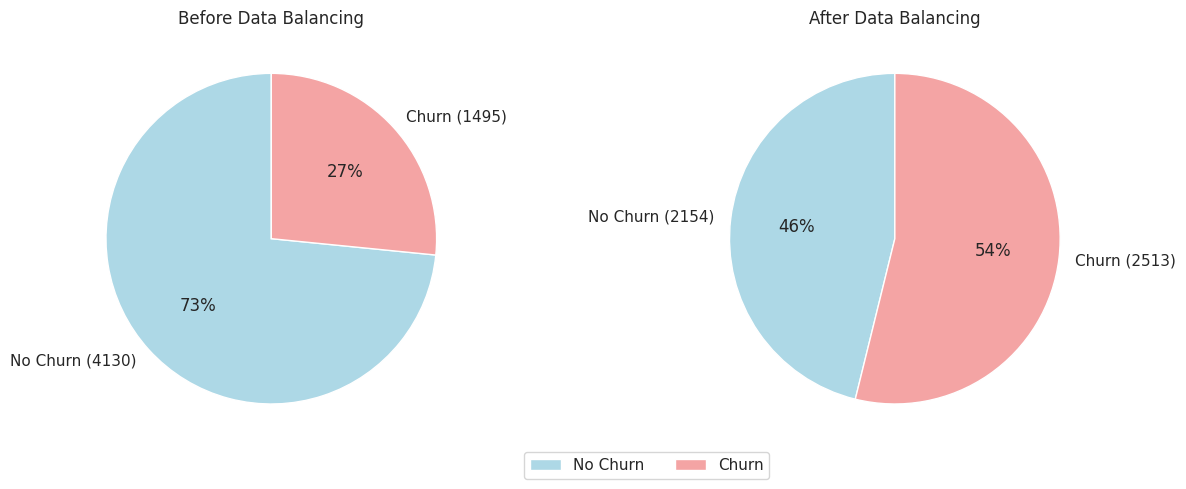

In [36]:
before_counts = y_train.value_counts().sort_index()
after_counts = y_resampled.value_counts().sort_index()

# Label dan warna berdasarkan urutan yang benar (misal No = 0, Yes = 1)
labels = ['No Churn', 'Churn']
colors = ['#ADD8E6', '#F4A4A4']  # biru muda dan peach

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart before balancing
axes[0].pie(
    before_counts,
    labels=[f'{labels[i]} ({before_counts.iloc[i]})' for i in range(2)],
    colors=colors,
    autopct='%1.0f%%',
    startangle=90
)
axes[0].set_title('Before Data Balancing')

# Pie chart after balancing
axes[1].pie(
    after_counts,
    labels=[f'{labels[i]} ({after_counts.iloc[i]})' for i in range(2)],
    colors=colors,
    autopct='%1.0f%%',
    startangle=90
)
axes[1].set_title('After Data Balancing')

plt.legend(labels, loc='lower center', bbox_to_anchor=(-0.1, -0.1), ncol=2)
plt.tight_layout()
plt.show()


In [38]:
from sklearn.ensemble import RandomForestClassifier


In [39]:
# Pengembangan dari Rizal
# Hyperparameter Tuning dengan GridSearchCV (untuk RandomForest)
from sklearn.model_selection import GridSearchCV

# Definisikan parameter yang ingin dicoba
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 6, 8],
    'min_samples_leaf': [1, 4, 8]
}

# Buat model dasar
rf = RandomForestClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Tampilkan parameter terbaik
print("Best Parameters:", grid_search.best_params_)

# Gunakan model terbaik
model_rf = grid_search.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'n_estimators': 150}


# Model Training

In [40]:
# Import matrix library
from sklearn import metrics # Import the metrics module
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Import model Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [41]:
# Membagi dataset yang telah di-resample menjadi data training dan testing
xr_train, xr_test, yr_train, yr_test = train_test_split(x_resampled, y_resampled, test_size=0.2)

## DesicionTreeClssifier

In [42]:
model_dt = DecisionTreeClassifier(
    criterion="gini",
    random_state=100,
    max_depth=6,
    min_samples_leaf=8
)

In [43]:
# Train dt model with the resampled data train
model_dt.fit(xr_train, yr_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [44]:
# Memprediksi hasil menggunakan model yang telah dilatih
yr_dt_pred = model_dt.predict(xr_test)

In [45]:
# Mengukur akurasi model terhadap data uji
model_score_dt = model_dt.score(xr_test, yr_test)

# Menampilkan skor akurasi model
print("Model Score:", model_score_dt, "\n")

# Menampilkan confusion matrix untuk membandingkan hasil prediksi dengan label sebenarnya
print("Confusion Matrix:")
print(metrics.confusion_matrix(yr_test, yr_dt_pred), "\n")

# Menampilkan laporan klasifikasi untuk melihat metrik evaluasi seperti precision, recall, dan f1-score
print("Classification Report:")
print(metrics.classification_report(yr_test, yr_dt_pred), "\n")

Model Score: 0.917558886509636 

Confusion Matrix:
[[373  37]
 [ 40 484]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       410
           1       0.93      0.92      0.93       524

    accuracy                           0.92       934
   macro avg       0.92      0.92      0.92       934
weighted avg       0.92      0.92      0.92       934
 



## RandomForestClassifier

In [46]:
model_rf = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    random_state=100,
    max_depth=6,
    min_samples_leaf=8
)

In [47]:
# Melatih model Random Forest yang telah dibuat dengan data latih hasil resampling
model_rf.fit(xr_train, yr_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [48]:
# Memprediksi hasil menggunakan model yang telah dilatih
yr_rf_pred = model_rf.predict(xr_test)

In [49]:
# Mengukur akurasi model terhadap data uji
model_score_rf = model_rf.score(xr_test, yr_test)

# Menampilkan skor akurasi model
print("Model Score:", model_score_rf, "\n")

# Menampilkan confusion matrix untuk membandingkan hasil prediksi dengan label sebenarnya
print("Confusion Matrix:")
print(metrics.confusion_matrix(yr_test, yr_rf_pred), "\n")

# Menampilkan laporan klasifikasi untuk melihat metrik evaluasi seperti precision, recall, dan f1-score
print("Classification Report:")
print(metrics.classification_report(yr_test, yr_rf_pred), "\n")

Model Score: 0.936830835117773 

Confusion Matrix:
[[374  36]
 [ 23 501]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       410
           1       0.93      0.96      0.94       524

    accuracy                           0.94       934
   macro avg       0.94      0.93      0.94       934
weighted avg       0.94      0.94      0.94       934
 



## XGBoost

In [50]:
model_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=100,
    min_child_weight=8,
    objective='binary:logistic'
)

In [51]:
# Melatih model XGBoost (model_xgb_smote) menggunakan data latih yang telah di-resample (xr_train2 dan yr_train2)
model_xgb.fit(xr_train,yr_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=100, ...)

In [52]:
# Menggunakan model XGBoost yang telah dilatih (model_xgb_smote) untuk membuat prediksi
yr_xgb_pred = model_xgb.predict(xr_test)

In [53]:
# Mengukur akurasi model terhadap data uji
model_score_xgb = model_xgb.score(xr_test, yr_test)

# Menampilkan skor akurasi model
print("Model Score:", model_score_xgb, "\n")

# Menampilkan confusion matrix untuk membandingkan hasil prediksi dengan label sebenarnya
print("Confusion Matrix:")
print(metrics.confusion_matrix(yr_test, yr_xgb_pred), "\n")

# Menampilkan laporan klasifikasi untuk melihat metrik evaluasi seperti precision, recall, dan f1-score
print("Classification Report:")
print(metrics.classification_report(yr_test, yr_xgb_pred), "\n")

Model Score: 0.9528907922912205 

Confusion Matrix:
[[385  25]
 [ 19 505]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       410
           1       0.95      0.96      0.96       524

    accuracy                           0.95       934
   macro avg       0.95      0.95      0.95       934
weighted avg       0.95      0.95      0.95       934
 



## Menambahkan Model Lain

In [54]:
# Pengembangan dari Rizal

### Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(xr_train, yr_train)
yr_lr_pred = model_lr.predict(xr_test)
print("Logistic Regression Accuracy:", model_lr.score(xr_test, yr_test))
print(classification_report(yr_test, yr_lr_pred))


Logistic Regression Accuracy: 0.936830835117773
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       410
           1       0.94      0.94      0.94       524

    accuracy                           0.94       934
   macro avg       0.94      0.94      0.94       934
weighted avg       0.94      0.94      0.94       934



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### SVM

In [56]:
from sklearn.svm import SVC

model_svm = SVC(kernel='rbf', probability=True)
model_svm.fit(xr_train, yr_train)
yr_svm_pred = model_svm.predict(xr_test)
print("SVM Accuracy:", model_svm.score(xr_test, yr_test))
print(classification_report(yr_test, yr_svm_pred))


SVM Accuracy: 0.8319057815845824
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       410
           1       0.84      0.87      0.85       524

    accuracy                           0.83       934
   macro avg       0.83      0.83      0.83       934
weighted avg       0.83      0.83      0.83       934



### LightGBM

In [57]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier()
model_lgb.fit(xr_train, yr_train)
yr_lgb_pred = model_lgb.predict(xr_test)
print("LightGBM Accuracy:", model_lgb.score(xr_test, yr_test))
print(classification_report(yr_test, yr_lgb_pred))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1989, number of negative: 1744
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 938
[LightGBM] [Info] Number of data points in the train set: 3733, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532815 -> initscore=0.131451
[LightGBM] [Info] Start training from score 0.131451
LightGBM Accuracy: 0.9528907922912205
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       410
           1       0.95      0.96      0.96       524

    accuracy                           0.95       934
   macro avg       0.95      0.95      0.95       934
weighted avg       0.95      0.95      0.95       934



### CatBoost

In [58]:
from catboost import CatBoostClassifier

model_cb = CatBoostClassifier(verbose=0)
model_cb.fit(xr_train, yr_train)
yr_cb_pred = model_cb.predict(xr_test)
print("CatBoost Accuracy:", model_cb.score(xr_test, yr_test))
print(classification_report(yr_test, yr_cb_pred))


CatBoost Accuracy: 0.9507494646680942
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       410
           1       0.95      0.97      0.96       524

    accuracy                           0.95       934
   macro avg       0.95      0.95      0.95       934
weighted avg       0.95      0.95      0.95       934



### Evaluasi Model Tambahan Dari Rizal

In [59]:
# ========== Evaluasi Model Tambahan ==========
print("\n=== Logistic Regression ===")
print("Accuracy:", model_lr.score(xr_test, yr_test))
print("Confusion Matrix:")
print(confusion_matrix(yr_test, model_lr.predict(xr_test)))
print("Classification Report:")
print(classification_report(yr_test, model_lr.predict(xr_test)))

print("\n=== Support Vector Machine (SVM) ===")
print("Accuracy:", model_svm.score(xr_test, yr_test))
print("Confusion Matrix:")
print(confusion_matrix(yr_test, model_svm.predict(xr_test)))
print("Classification Report:")
print(classification_report(yr_test, model_svm.predict(xr_test)))

print("\n=== LightGBM ===")
print("Accuracy:", model_lgb.score(xr_test, yr_test))
print("Confusion Matrix:")
print(confusion_matrix(yr_test, model_lgb.predict(xr_test)))
print("Classification Report:")
print(classification_report(yr_test, model_lgb.predict(xr_test)))

print("\n=== CatBoost ===")
print("Accuracy:", model_cb.score(xr_test, yr_test))
print("Confusion Matrix:")
print(confusion_matrix(yr_test, model_cb.predict(xr_test)))
print("Classification Report:")
print(classification_report(yr_test, model_cb.predict(xr_test)))



=== Logistic Regression ===
Accuracy: 0.936830835117773
Confusion Matrix:
[[380  30]
 [ 29 495]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       410
           1       0.94      0.94      0.94       524

    accuracy                           0.94       934
   macro avg       0.94      0.94      0.94       934
weighted avg       0.94      0.94      0.94       934


=== Support Vector Machine (SVM) ===
Accuracy: 0.8319057815845824
Confusion Matrix:
[[322  88]
 [ 69 455]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       410
           1       0.84      0.87      0.85       524

    accuracy                           0.83       934
   macro avg       0.83      0.83      0.83       934
weighted avg       0.83      0.83      0.83       934


=== LightGBM ===
Accuracy: 0.9528907922912205
Confusion Matrix:
[[386  24]
 [ 20 504]]
Classi

## Choose Best Model

In [60]:
# Menunjukkan skor akurasi untuk tiga model yang telah dilatih dan di-resample menggunakan SMOTEENN
print("Decision Tree Classifier : ", model_score_dt)
print("Random Forest Classifier :", model_score_rf)
print("XGBoost Classifier       : ", model_score_xgb)

# Pengembangan dari Rizal
print("Logistic Regression Accuracy:", model_lr.score(xr_test, yr_test))
print("SVM Accuracy:", model_svm.score(xr_test, yr_test))
print("LightGBM Accuracy:", model_lgb.score(xr_test, yr_test))
print("CatBoost Accuracy:", model_cb.score(xr_test, yr_test))

Decision Tree Classifier :  0.917558886509636
Random Forest Classifier : 0.936830835117773
XGBoost Classifier       :  0.9528907922912205
Logistic Regression Accuracy: 0.936830835117773
SVM Accuracy: 0.8319057815845824
LightGBM Accuracy: 0.9528907922912205
CatBoost Accuracy: 0.9507494646680942


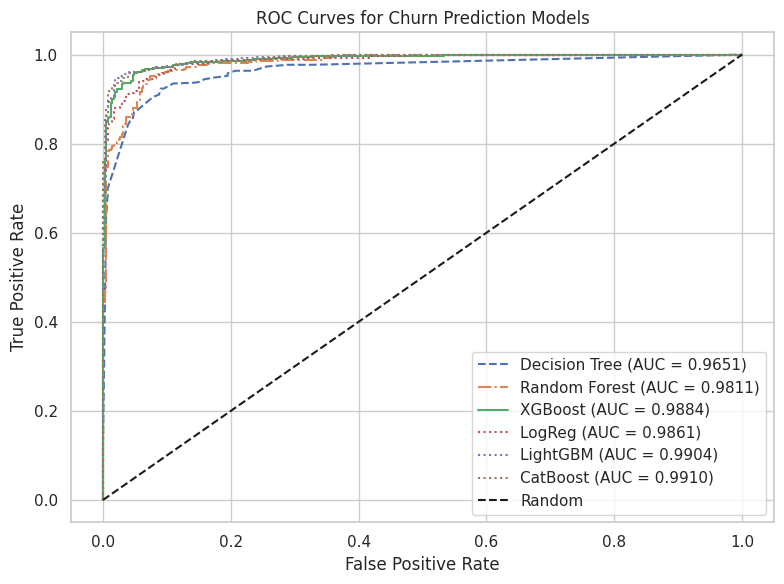

In [61]:
# 1. Probabilitas prediksi untuk masing-masing model
y_dt_proba = model_dt.predict_proba(xr_test)[:, 1]
y_rf_proba = model_rf.predict_proba(xr_test)[:, 1]
y_xgb_proba = model_xgb.predict_proba(xr_test)[:, 1]
# --------- (
# Pengembangan dari Rizal
y_lr_proba = model_lr.predict_proba(xr_test)[:, 1]
y_lgb_proba = model_lgb.predict_proba(xr_test)[:, 1]
y_cb_proba = model_cb.predict_proba(xr_test)[:, 1]
# --------- )

# 2. Hitung fpr dan tpr
fpr_dt, tpr_dt, _ = roc_curve(yr_test, y_dt_proba)
fpr_rf, tpr_rf, _ = roc_curve(yr_test, y_rf_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(yr_test, y_xgb_proba)
# --------- (
# Pengembangan dari Rizal
fpr_lr, tpr_lr, _ = roc_curve(yr_test, y_lr_proba)
fpr_lgb, tpr_lgb, _ = roc_curve(yr_test, y_lgb_proba)
fpr_cb, tpr_cb, _ = roc_curve(yr_test, y_cb_proba)
# --------- )

# 3. Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_score(yr_test, y_dt_proba):.4f})', linestyle='--')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(yr_test, y_rf_proba):.4f})', linestyle='-.')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(yr_test, y_xgb_proba):.4f})', linestyle='-')
# --------- (
# Pengembangan dari Rizal
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC = {roc_auc_score(yr_test, y_lr_proba):.4f})', linestyle=':')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {roc_auc_score(yr_test, y_lgb_proba):.4f})', linestyle=':')
plt.plot(fpr_cb, tpr_cb, label=f'CatBoost (AUC = {roc_auc_score(yr_test, y_cb_proba):.4f})', linestyle=':')
# --------- )

# 4. Garis baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# 5. Label dan tampilan
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Churn Prediction Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

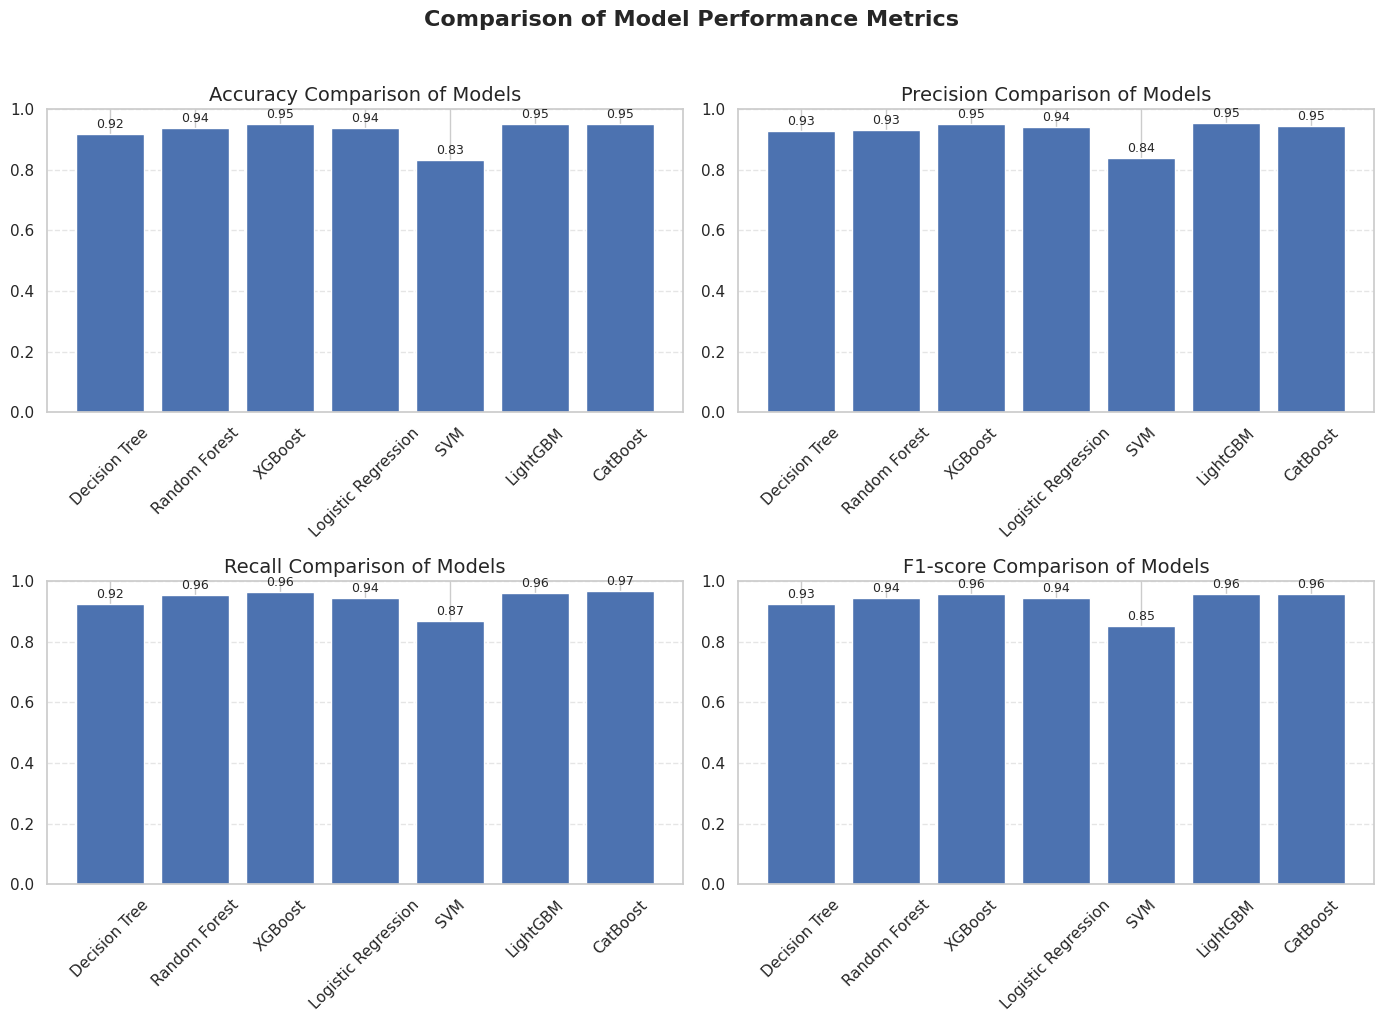

In [62]:
from sklearn.metrics import accuracy_score

model_scores = {}

# Decision Tree
yr_dt_pred = model_dt.predict(xr_test)
report_dt = classification_report(yr_test, yr_dt_pred, output_dict=True)
acc_dt = accuracy_score(yr_test, yr_dt_pred)
model_scores['Decision Tree'] = {
    'Accuracy': acc_dt,
    'Precision': report_dt['1']['precision'],
    'Recall': report_dt['1']['recall'],
    'F1-score': report_dt['1']['f1-score']
}

# Random Forest
yr_rf_pred = model_rf.predict(xr_test)
report_rf = classification_report(yr_test, yr_rf_pred, output_dict=True)
acc_rf = accuracy_score(yr_test, yr_rf_pred)
model_scores['Random Forest'] = {
    'Accuracy': acc_rf,
    'Precision': report_rf['1']['precision'],
    'Recall': report_rf['1']['recall'],
    'F1-score': report_rf['1']['f1-score']
}

# XGBoost
yr_xgb_pred = model_xgb.predict(xr_test)
report_xgb = classification_report(yr_test, yr_xgb_pred, output_dict=True)
acc_xgb = accuracy_score(yr_test, yr_xgb_pred)
model_scores['XGBoost'] = {
    'Accuracy': acc_xgb,
    'Precision': report_xgb['1']['precision'],
    'Recall': report_xgb['1']['recall'],
    'F1-score': report_xgb['1']['f1-score']
}

# ------ (
# Pengembangan dari Rizal
# Tambahkan ke dict model_scores
report_lr = classification_report(yr_test, yr_lr_pred, output_dict=True)
report_svm = classification_report(yr_test, yr_svm_pred, output_dict=True)
report_lgb = classification_report(yr_test, yr_lgb_pred, output_dict=True)
report_cb = classification_report(yr_test, yr_cb_pred, output_dict=True)

model_scores['Logistic Regression'] = {
    'Accuracy': accuracy_score(yr_test, yr_lr_pred),
    'Precision': report_lr['1']['precision'],
    'Recall': report_lr['1']['recall'],
    'F1-score': report_lr['1']['f1-score']
}

model_scores['SVM'] = {
    'Accuracy': accuracy_score(yr_test, yr_svm_pred),
    'Precision': report_svm['1']['precision'],
    'Recall': report_svm['1']['recall'],
    'F1-score': report_svm['1']['f1-score']
}

model_scores['LightGBM'] = {
    'Accuracy': accuracy_score(yr_test, yr_lgb_pred),
    'Precision': report_lgb['1']['precision'],
    'Recall': report_lgb['1']['recall'],
    'F1-score': report_lgb['1']['f1-score']
}

model_scores['CatBoost'] = {
    'Accuracy': accuracy_score(yr_test, yr_cb_pred),
    'Precision': report_cb['1']['precision'],
    'Recall': report_cb['1']['recall'],
    'F1-score': report_cb['1']['f1-score']
}
# ------ )

# Ubah dict ke DataFrame
df_scores = pd.DataFrame(model_scores).T

# Buat bar plot per metrik
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

plt.figure(figsize=(14, 10))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    plt.bar(df_scores.index, df_scores[metric])
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.title(f"{metric} Comparison of Models", fontsize=14)
    plt.ylim(0, 1)
    for idx, val in enumerate(df_scores[metric]):
        plt.text(idx, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=9)
    plt.xticks(rotation=45)
plt.suptitle("Comparison of Model Performance Metrics", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

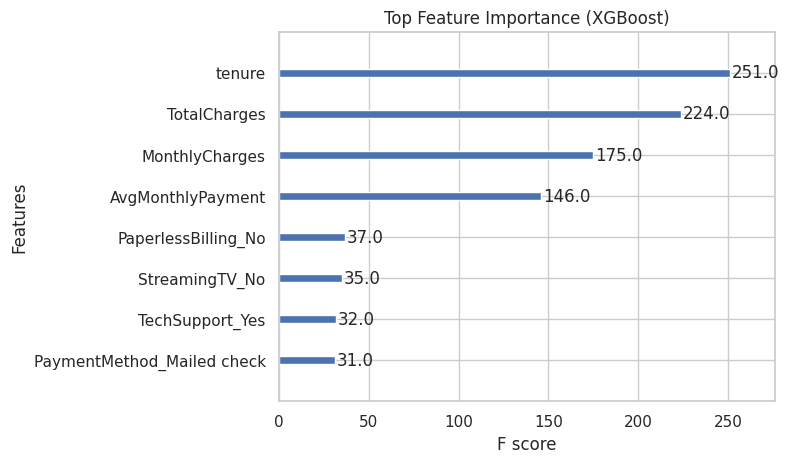

In [63]:
# Feature Importance Plot
import xgboost
xgboost.plot_importance(model_xgb, max_num_features=8) # Use xgboost.plot_importance instead of model_xgb.plot_importance
plt.title('Top Feature Importance (XGBoost)')
plt.show()

In [64]:
# --------- (
# Pengembangan dari Rizal
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model_xgb, x_resampled, y_resampled, cv=5)
print("Cross-Validation Mean Score (XGBoost):", np.mean(cv_scores))
# --------- )

Cross-Validation Mean Score (XGBoost): 0.9473022255577664


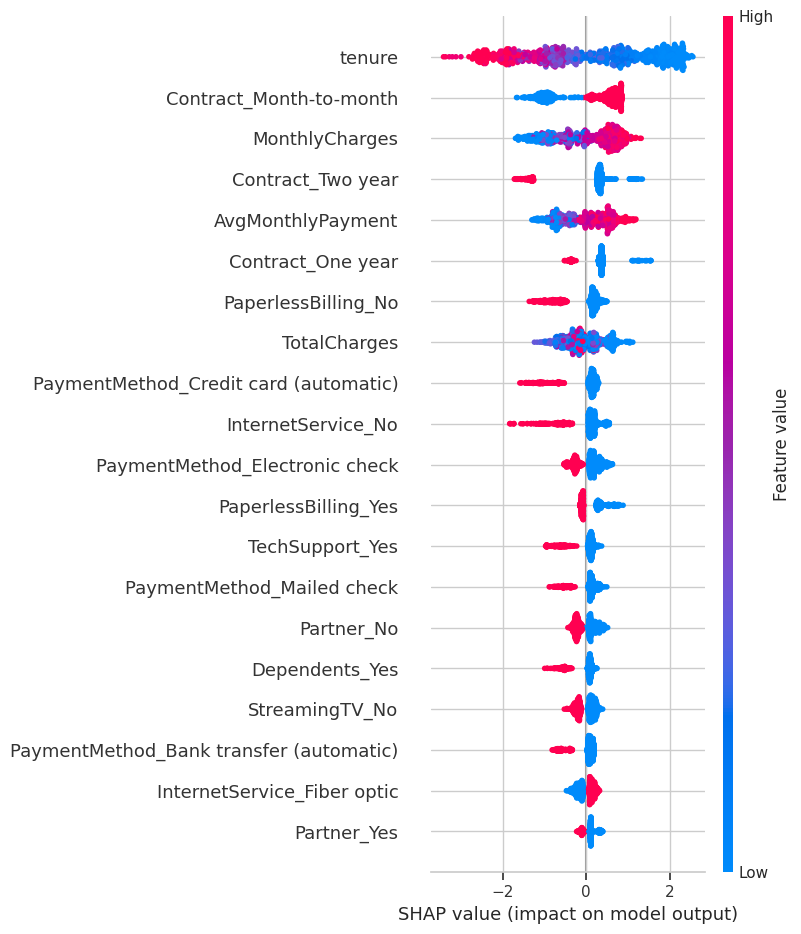

In [65]:
# SHAP Value Visualization (Opsional, Bonus)
import shap
explainer = shap.Explainer(model_xgb)
shap_values = explainer(xr_test)

shap.summary_plot(shap_values, xr_test, feature_names=xr_test.columns)

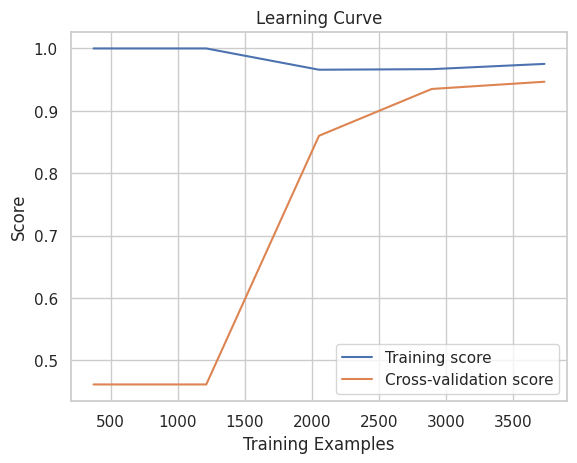

In [66]:
# Learning Curve (untuk tunjukkan performa model terhadap jumlah data)

from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(model_xgb, x_resampled, y_resampled, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

## Save Model

In [67]:
import joblib

In [68]:
# Menentukan nama file ('model.sav') untuk menyimpan model yang telah dilatih
filename = 'model.pkl'

joblib.dump(model_xgb, open(filename, 'wb'))
load_model = joblib.load(open(filename, 'rb'))
model_score_xgb = load_model.score(xr_test, yr_test)

# Menampilkan skor evaluasi model XGBoost pada data uji
model_score_xgb

0.9528907922912205

# Data Testing




In [69]:
# Data testing (input baru)
input_data = {
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'PhoneService': 'No',
    'MultipleLines': 'No phone service',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 29.85,
    'TotalCharges': 29.85,
    'tenure_group': '1 - 12'  # Add tenure_group
}

# Konversi dictionary ke DataFrame
input_df = pd.DataFrame([input_data])

# Load model XGBoost yang sudah dilatih
filename = 'model.pkl'
model_xgb_smote = joblib.load(open(filename, 'rb'))

# --- Apply one-hot encoding ---
# Get all categorical features from the input data
categorical_features = input_df.select_dtypes(include=['object']).columns

# Create a DataFrame with one-hot encoded features
encoded_features = pd.get_dummies(input_df[categorical_features])

# Concatenate encoded features with numerical features
input_df = pd.concat([input_df, encoded_features], axis=1)

# Remove original categorical features
input_df = input_df.drop(columns=categorical_features)

# --- Get missing columns and add them to input_df ---
# Get the feature names from the trained model
training_features = model_xgb.get_booster().feature_names

# Find missing columns
missing_cols = set(training_features) - set(input_df.columns)

# Add missing columns with value 0
for col in missing_cols:
    input_df[col] = 0

# Reorder the columns in input_df to match training_features
input_df = input_df[training_features]
# --- End of one-hot encoding ---

# Prediksi churn atau tidak churn
# prediction = model_xgb.predict(input_df)
# pred_prob = model_xgb.predict_proba(input_df)
# Perubahan oleh rizal
prediction = model_xgb_smote.predict(input_df)
pred_prob = model_xgb_smote.predict_proba(input_df)


# Output hasil prediksi
print(f"Prediction: {'Churn' if prediction[0] == 1 else 'No Churn'}")
print(f"Prediciton Probability: {pred_prob}")

Prediction: Churn
Prediciton Probability: [[0.02195978 0.9780402 ]]


In [70]:
from google.colab import files
files.download('model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Deployment

In [72]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.0 MB/s eta 0:00:00


In [73]:
import streamlit as st
import pandas as pd
import joblib

# Load model
model = joblib.load("model.pkl")

st.title("📊 Telco Customer Churn Prediction")

SeniorCitizen = st.selectbox("Senior Citizen", [0, 1])
Partner = st.selectbox("Partner", ["Yes", "No"])
Dependents = st.selectbox("Dependents", ["Yes", "No"])
PhoneService = st.selectbox("Phone Service", ["Yes", "No"])
InternetService = st.selectbox("Internet Service", ["DSL", "Fiber optic", "No"])
Contract = st.selectbox("Contract", ["Month-to-month", "One year", "Two year"])
MonthlyCharges = st.number_input("Monthly Charges", 0.0)
TotalCharges = st.number_input("Total Charges", 0.0)
tenure_group = st.selectbox("Tenure Group", [
    "1 - 12", "13 - 24", "25 - 36", "37 - 48", "49 - 60", "61 - 72"
])

if st.button("Predict"):
    input_data = {
        'SeniorCitizen': SeniorCitizen,
        'Partner': Partner,
        'Dependents': Dependents,
        'PhoneService': PhoneService,
        'InternetService': InternetService,
        'Contract': Contract,
        'MonthlyCharges': MonthlyCharges,
        'TotalCharges': TotalCharges,
        'tenure_group': tenure_group
    }
    df = pd.DataFrame([input_data])
    df_encoded = pd.get_dummies(df)

    # Padding kolom
    for col in model.get_booster().feature_names:
        if col not in df_encoded.columns:
            df_encoded[col] = 0
    df_encoded = df_encoded[model.get_booster().feature_names]

    pred = model.predict(df_encoded)[0]
    st.success("✅ Prediction: Churn" if pred == 1 else "✅ Prediction: No Churn")


2025-05-25 08:04:06.202 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 08:04:06.519 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-05-25 08:04:06.526 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 08:04:06.528 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 08:04:06.536 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 08:04:06.540 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 08:04:06.547 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 08:04:06.549 Session state does not 

In [76]:
import joblib
joblib.dump(model_xgb, 'model.pkl')


['model.pkl']